In [1]:
from glob import glob
import numpy as np
from parcels import FieldSet, ParticleSet, JITParticle
from parcels import ErrorCode, AdvectionRK4_3D, Variable
from datetime import timedelta
# from os import path
from datetime import datetime
# from parcels import ParcelsRandom
# import math
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Lorenz - MOi fields
data_path = '/storage/shared/oceanparcels/input_data/MOi/2019/'
bio_data_path = '/storage/shared/oceanparcels/input_data/MOi/biomer4v2r1/'

output_path = '/storage/shared/oceanparcels/output_data/' + \
    'data_Claudio/backtrack_loc0_column.nc'

ufiles = sorted(glob(data_path + 'psy4v3r1-daily_U_2019*.nc'))
vfiles = sorted(glob(data_path + 'psy4v3r1-daily_V_2019*.nc'))
wfiles = sorted(glob(data_path + 'psy4v3r1-daily_W_2019*.nc'))
tfiles = sorted(glob(data_path + 'psy4v3r1-daily_T_2019*.nc'))    
sfiles = sorted(glob(data_path + 'psy4v3r1-daily_S_2019*.nc'))
twoDfiles = sorted(glob(data_path + 'psy4v3r1-daily_2D_2019*.nc'))

phfiles = sorted(glob(bio_data_path + 'biomer4v2r1-weekly_ph_2019*.nc'))

mesh_mask = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/coordinates.nc'
mesh_mask_bio = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA025-N006/coordinates.nc'

In [3]:
filenames = {'U': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': ufiles},
             'V': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': vfiles},
             'W': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': wfiles}}

filenames['temperature'] = {'lon': mesh_mask, 
                                 'lat': mesh_mask, 
                                 'depth': wfiles[0], 
                                 'data': tfiles}
filenames['salinity'] = {'lon': mesh_mask, 
                             'lat': mesh_mask, 
                             'depth': wfiles[0], 
                             'data': sfiles}

filenames['mld'] = {'lon': mesh_mask, 
                     'lat': mesh_mask,
                     'depth': twoDfiles[0],
                     'data': twoDfiles}


In [4]:
n_points = 1000
# start_time = datetime.strptime('2007-08-22 12:00:00', '%Y-%m-%d %H:%M:%S')

# start_time = datetime.strptime('2010-12-20 12:00:00', '%Y-%m-%d %H:%M:%S')
start_time = datetime.strptime('2019-12-02 12:00:00', '%Y-%m-%d %H:%M:%S')
# psy4v3r1-daily_2D_2019-01-01.nc

variables = {'U': 'vozocrtx',
             'V': 'vomecrty',
             'W': 'vovecrtz'}

variables['temperature'] = 'votemper'
variables['salinity'] = 'vosaline'
variables['mld'] = 'somxlavt'

dimensions = {'U': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'},
              'V': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'},
              'W': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'}}

dimensions['temperature'] = {'lon': 'glamf', 
                                  'lat': 'gphif',
                                  'depth': 'depthw', 
                                  'time': 'time_counter'}

dimensions['salinity'] = {'lon': 'glamf', 
                              'lat': 'gphif',
                              'depth': 'depthw', 
                              'time': 'time_counter'}

dimensions['mld'] = {'lon': 'glamf', 
                              'lat': 'gphif',
                              'depth': 'deptht', 
                              'time': 'time_counter'}



In [5]:
filenames_bio = {'ph': {'lon': mesh_mask_bio, 
                              'lat': mesh_mask_bio, 
                              'depth': wfiles[0], 
                              'data': phfiles}}

variables_bio = {'ph': 'ph'}

dimensions_bio = {'ph': {'lon': 'glamf', 
                               'lat': 'gphif', 
                               'depth': 'depthw', 
                               'time': 'time_counter'}}

In [6]:
indices = {'lat': range(750, 1300), 'lon': range(2900, 4000)}

In [7]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                              allow_time_extrapolation=False,
                              indices=indices)

bio_fieldset = FieldSet.from_nemo(filenames_bio, variables_bio, dimensions_bio)

fieldset.add_field(bio_fieldset.ph)

         It will be opened with no decoding. Filling values might be wrongly parsed.
         It will be opened with no decoding. Filling values might be wrongly parsed.


In [8]:
class PlasticParticle(JITParticle):
    temperature = Variable('temperature', dtype=np.float32, initial=0)
    salinity = Variable('salinity', dtype=np.float32, initial=0)
    ph = Variable('ph', dtype=np.float32, initial=0)
    mld = Variable('mld', dtype=np.float32, initial=0)
    

In [9]:
lon_cluster = [6.287]*n_points
lat_cluster = [-32.171]*n_points

# depth_cluster = np.linspace(1, 5000, n_points)
depth_cluster = np.ones(n_points)*5179 #meters

date_cluster = [start_time]*n_points

lon_cluster = np.array(lon_cluster)+(np.random.random(len(lon_cluster))-0.5)/24
lat_cluster = np.array(lat_cluster)+(np.random.random(len(lat_cluster))-0.5)/24

In [10]:
pset = ParticleSet.from_list(fieldset=fieldset, pclass=PlasticParticle,
                             lon=lon_cluster,
                             lat=lat_cluster,
                             depth=depth_cluster,
                             time=date_cluster)


In [11]:
def delete_particle(particle, fieldset, time):
    particle.delete()

In [12]:
def SampleField(particle, fielset, time):
    particle.temperature = fieldset.temperature[time, particle.depth, 
                                               particle.lat, particle.lon]
    particle.salinity = fieldset.salinity[time, particle.depth, 
                                               particle.lat, particle.lon]
    particle.ph = fieldset.ph[time, particle.depth, 
                                               particle.lat, particle.lon]
    particle.mld = fieldset.mld[time, particle.depth, 
                                               particle.lat, particle.lon]
    
#sample_kernel = pset.Kernel(sample_field) 

In [13]:
kernels = pset.Kernel(AdvectionRK4_3D) + pset.Kernel(SampleField) 

# Output file
output_file = pset.ParticleFile(name=output_path,
                                outputdt=timedelta(hours=24))

pset.execute(kernels,
             output_file=output_file,
             runtime=timedelta(days=10),
             dt=-timedelta(hours=1),
             recovery={ErrorCode.ErrorOutOfBounds: delete_particle})

output_file.close()


sh: None: command not found
INFO: Compiled ArrayPlasticParticleAdvectionRK4_3DSampleField ==> /tmp/parcels-263482/libed1dcbf7a75b5acbfb0c60a6fdbabfb1_0.so
INFO: Temporary output files are stored in /storage/shared/oceanparcels/output_data/data_Claudio/out-OYRQWCZQ.
INFO: You can use "parcels_convert_npydir_to_netcdf /storage/shared/oceanparcels/output_data/data_Claudio/out-OYRQWCZQ" to convert these to a NetCDF file during the run.
100% (864000.0 of 864000.0) |############| Elapsed Time: 0:02:23 Time:  0:02:23


In [14]:
sim = xr.load_dataset(output_path)

In [15]:
sim

<xarray.Dataset>
Dimensions:      (traj: 1000, obs: 11)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory   (traj, obs) float64 0.0 0.0 0.0 0.0 ... 999.0 999.0 999.0 999.0
    time         (traj, obs) datetime64[ns] 2019-12-02T12:00:00 ... 2019-11-2...
    lat          (traj, obs) float64 -32.18 -32.23 -32.27 ... -32.42 -32.45
    lon          (traj, obs) float64 6.293 6.428 6.482 ... 6.972 6.985 7.02
    z            (traj, obs) float64 5.179e+03 5.152e+03 ... 5.236e+03 5.261e+03
    temperature  (traj, obs) float32 0.0 0.7206 0.7095 ... 0.6928 0.6945 0.6957
    salinity     (traj, obs) float32 0.0 34.74 34.74 34.74 ... 34.74 34.74 34.74
    ph           (traj, obs) float32 0.0 7.789 7.802 7.802 ... 7.788 7.788 7.788
    mld          (traj, obs) float32 0.0 15.49 14.16 17.38 ... 22.98 32.8 39.77
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-40-g6423cc0e
    parcels_mesh:           spherical

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

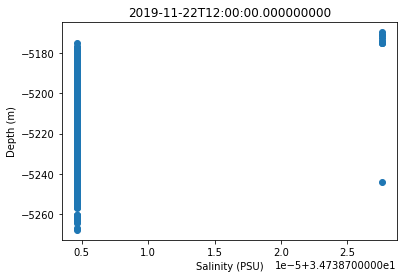

In [19]:
step = 10
plt.scatter(sim['salinity'][:,step], -sim['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

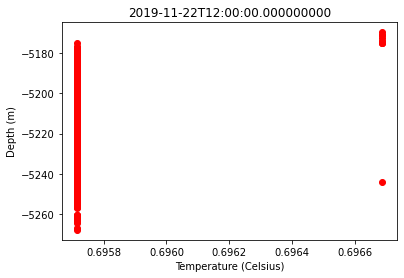

In [20]:
step = 10
plt.scatter(sim['temperature'][:,step], -sim['z'][:,step], color='r')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

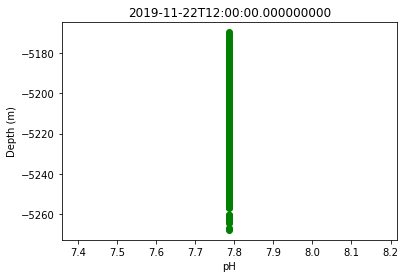

In [21]:
step = 10
plt.scatter(sim['ph'][:,step], -sim['z'][:,step], color='g')
plt.xlabel('pH')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0, 0.5, 'Latitude')

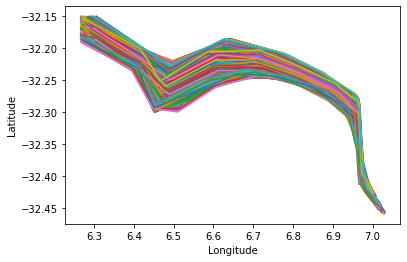

In [23]:
step = 10
for i in range(1000):
    plt.plot(sim['lon'][i,:], sim['lat'][i,:]);

plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title(sim['time'][0,step].values)

In [24]:
sim2 = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_loc0_column_biotest1.nc')

In [46]:
sim2

<xarray.Dataset>
Dimensions:     (traj: 100, obs: 11)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 0.0 ... 99.0 99.0 99.0 99.0
    time        (traj, obs) datetime64[ns] 2019-12-02T12:00:00 ... 2019-11-22...
    lat         (traj, obs) float64 -32.17 -32.12 -32.07 ... -32.34 -32.34
    lon         (traj, obs) float64 6.287 6.459 6.649 6.89 ... 7.11 7.149 7.186
    z           (traj, obs) float64 1.0 0.9974 0.9571 ... 4.994e+03 4.993e+03
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-40-g6423cc0e
    parcels_mesh:           spherical

In [45]:
step = 10
plt.scatter(sim2['salinity'][:,step], -sim2['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim2['time'][0,step].values)

KeyError: 'salinity'